# Simulating Poisson typing behavior


## Set up


In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src import plot
from src import util

## Run simulation

Simulates typing as a poisson process in discrete time, where in each time bin there
is a probability of either typing a correct letter, a wrong letter, or no letter at all.

Error of approximating Poisson as Bernoulli is determined by ratio of time step (dt)
to characters per second (avg_correct_cps)
Error leads to slightly lower wpm than expected, but is negligible for reasonable
values of dt and avg_correct_cps

Incorporrates an error time cost (each error causes a delay in typing, in order to fix it).
Set error_cost=0 to assume no cost to correcting errors.


In [3]:
# Set rng
np.random.seed(0)
# Run simulation
avg_wpm = 60
avg_acc = 0.95
error_cost = 0.0
dt = 0.005
n_trials = 1000
wpm, acc, n_mistakes = util.run_simulation_poisson(
    avg_wpm=avg_wpm, avg_acc=avg_acc, error_cost=error_cost, dt=dt, n_trials=n_trials
)

Average WPM: 59.84760000000001
Average Accuracy: 0.9491996685949516


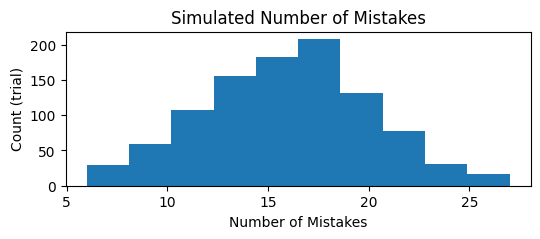

In [4]:
# Plot a histogram of the number of mistakes per trial
fig = plt.figure(figsize=(6, 2))
ax = plot.sim_n_mistakes(n_mistakes)
plt.show()

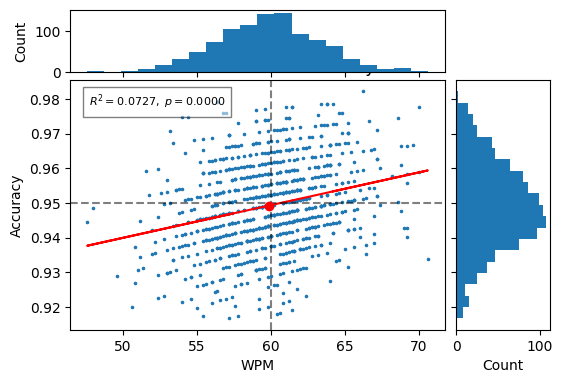

In [5]:
# Plot scatter_hist of wpm and acc
fig = plt.figure(figsize=(6, 4))
ax, ax_histx, ax_histy = plot.sim_scatter_hist(wpm, acc, fig=fig)
ax.axvline(avg_wpm, color="k", linestyle="--", alpha=0.5)
ax.axhline(avg_acc, color="k", linestyle="--", alpha=0.5)
ax.plot(np.mean(wpm), np.mean(acc), "ro")
plt.show()

## Non-zero error cost


In [6]:
# Set rng
np.random.seed(0)
# Run simulation
avg_wpm = 60
avg_acc = 0.95
error_cost = 0.75
dt = 0.005
n_trials = 1000
wpm, acc, n_mistakes = util.run_simulation_poisson(
    avg_wpm=avg_wpm, avg_acc=avg_acc, error_cost=error_cost, dt=dt, n_trials=n_trials
)

Average WPM: 59.2764
Average Accuracy: 0.948836860468977


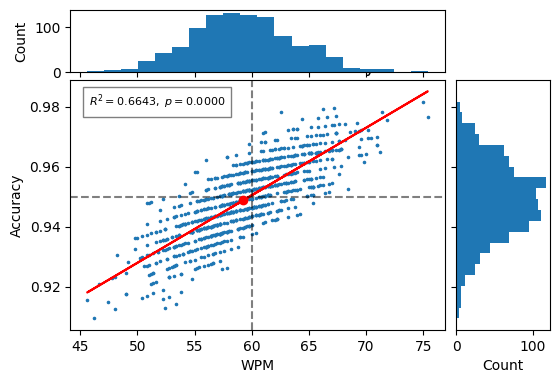

In [7]:
# Plot scatter_hist of wpm and acc
fig = plt.figure(figsize=(6, 4))
ax, ax_histx, ax_histy = plot.sim_scatter_hist(wpm, acc, fig=fig)
ax.axvline(avg_wpm, color="k", linestyle="--", alpha=0.5)
ax.axhline(avg_acc, color="k", linestyle="--", alpha=0.5)
ax.plot(np.mean(wpm), np.mean(acc), "ro")
plt.show()